# Fine-tuning GPT-OSS (20B) as a Multilingual Reasoning Model with Unsloth

In this notebook, we'll walkthrough how OpenAI's open-weight reasoning model `gpt-oss-20b` can be fine-tuned to **reason effectively in multiple languages**. We'll do this by:
1. Fine-tuning with [Unsloth](https://github.com/unslothai/unsloth) for 2x faster training
2. Using a multilingual reasoning dataset where chain-of-thought has been translated

The end result? A model that can generate reasoning steps in French, Spanish, German, Italian, and other languages. You can even **mix languages**:

```
User: I buy a book for $15 and a coffee for $4.50. The sales tax is 8%. What is the total cost?
System: reasoning language: French

Assistant reasoning (in French):
L'utilisateur achète un livre pour 15$ et un café pour 4,50$.
Le total avant taxes est 15 + 4,50 = 19,50$.
La taxe de vente est de 8%, donc 19,50 × 0,08 = 1,56$.
Le coût total est 19,50 + 1,56 = 21,06$.

Assistant response:
The total cost is $21.06.
```

This enables AI developers working with under-represented languages to improve the interpretability of reasoning models in their native languages.

### Installation

In [1]:
%%capture
# We're installing the latest Torch, Triton, OpenAI's Triton kernels, Transformers and Unsloth!
!pip install --upgrade -qqq uv
try: import numpy; get_numpy = f"numpy=={numpy.__version__}"
except: get_numpy = "numpy"
!uv pip install -qqq \
    "torch>=2.8.0" "triton>=3.4.0" {get_numpy} torchvision bitsandbytes \
    "unsloth_zoo[base] @ git+https://github.com/unslothai/unsloth-zoo" \
    "unsloth[base] @ git+https://github.com/unslothai/unsloth" \
    git+https://github.com/huggingface/transformers \
    git+https://github.com/triton-lang/triton.git@05b2c186c1b6c9a08375389d5efe9cb4c401c075#subdirectory=python/triton_kernels

### Loading the Model with Unsloth

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 1024
dtype = None

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/gpt-oss-20b-unsloth-bnb-4bit", # 20B model using bitsandbytes 4bit quantization
    "unsloth/gpt-oss-120b-unsloth-bnb-4bit",
    "unsloth/gpt-oss-20b", # 20B model using MXFP4 format
    "unsloth/gpt-oss-120b",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/gpt-oss-20b",
    dtype = dtype, # None for auto detection
    max_seq_length = max_seq_length, # Choose any for long context!
    load_in_4bit = True,  # 4 bit quantization to reduce memory
    full_finetuning = False, # [NEW!] We have full finetuning now!
    # token = "hf_...", # use one if using gated models
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.9: Fast Gpt_Oss patching. Transformers: 4.56.0.dev0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gpt_oss won't work! Using float32.
Unsloth: Gpt_Oss does not support SDPA - switching to fast eager.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.37G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/165 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/27.9M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth: Making `model.base_model.model.model` require gradients


### Understanding Reasoning Effort Levels

The `gpt-oss` models include a unique feature that allows you to adjust the model's **"reasoning effort"**—controlling the trade-off between performance and response speed (latency) by adjusting how many tokens the model uses to think.

----

Three distinct levels:
* **Low**: Optimized for fast responses, minimal multi-step reasoning
* **Medium**: Balanced performance and speed
* **High**: Strongest reasoning performance for complex tasks (higher latency)

In [4]:
from transformers import TextStreamer

messages = [
    {"role": "user", "content": "I buy a book for $15 and a coffee for $4.50. The sales tax is 8%. What is the total cost?"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt",
    return_dict = True,
    reasoning_effort = "low",
).to(model.device)

_ = model.generate(**inputs, max_new_tokens = 512, streamer = TextStreamer(tokenizer))

<|start|>system<|message|>You are ChatGPT, a large language model trained by OpenAI.
Knowledge cutoff: 2024-06
Current date: 2025-08-26

Reasoning: low

# Valid channels: analysis, commentary, final. Channel must be included for every message.
Calls to these tools must go to the commentary channel: 'functions'.<|end|><|start|>user<|message|>I buy a book for $15 and a coffee for $4.50. The sales tax is 8%. What is the total cost?<|end|><|start|>assistant<|channel|>analysis<|message|>We compute: 15 + 4.5 = 19.5. Tax 8% of 19.5 = 1.56. Total = 21.06. We'll output.<|end|><|start|>assistant<|channel|>final<|message|>Step‑by‑step:

1. **Subtotal (before tax)**  
   \[
   15.00\ \text{(book)} + 4.50\ \text{(coffee)} = 19.50
   \]

2. **Sales tax**  
   \[
   \text{Tax} = 19.50 \times 0.08 = 1.56
   \]

3. **Total cost**  
   \[
   \text{Total} = 19.50 + 1.56 = 21.06
   \]

**Total cost: \$21.06**.<|return|>


Changing the `reasoning_effort` to `high` will make the model think longer. We have to increase the `max_new_tokens` to occupy the amount of the generated tokens but it will give better and more correct answer

In [5]:
from transformers import TextStreamer

messages = [
    {"role": "user", "content": "I buy a book for $15 and a coffee for $4.50. The sales tax is 8%. What is the total cost?"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt",
    return_dict = True,
    reasoning_effort = "high",
).to(model.device)

_ = model.generate(**inputs, max_new_tokens = 2048, streamer = TextStreamer(tokenizer))

<|start|>system<|message|>You are ChatGPT, a large language model trained by OpenAI.
Knowledge cutoff: 2024-06
Current date: 2025-08-26

Reasoning: high

# Valid channels: analysis, commentary, final. Channel must be included for every message.
Calls to these tools must go to the commentary channel: 'functions'.<|end|><|start|>user<|message|>I buy a book for $15 and a coffee for $4.50. The sales tax is 8%. What is the total cost?<|end|><|start|>assistant<|channel|>analysis<|message|>The user: "I buy a book for $15 and a coffee for $4.50. The sales tax is 8%. What is the total cost?" They want the total cost of the purchase. This is a straightforward arithmetic problem.

Book cost: $15. Coffee cost: $4.50. Total before tax: $15 + $4.50 = $19.50.

Sales tax 8% of the subtotal: 0.08 × 19.50 = $1.56. (But we can compute exactly: 19.50 * 0.08 = (1950 * 0.08)/100 so 155.999? Wait: 19.50 * 8% = 19.50 * 0.08 = 1.56. Yes exactly since 19.5 * 8% = 1.56.

Add tax to subtotal: $19.50 + $1.56 = $21

<a name="Data"></a>
### Data Prep: The Multilingual Reasoning Dataset

We'll use the [HuggingFaceH4/Multilingual-Thinking](https://huggingface.co/datasets/HuggingFaceH4/Multilingual-Thinking) dataset.
- It contains reasoning chains translated into multiple languages (French, Spanish, German, Italian)
- Each example has both the reasoning process (`analysis` channel) and final answer (`final` channel)
- By training on this, the model learns to generate reasoning steps in different languages

### Understanding the Harmony Format

The GPT-OSS models use OpenAI's Harmony format for conversations. Here's what each field means:

| Field | Purpose |
|-------|---------|
| `developer` | Custom instructions for the model (similar to system role) |
| `user` | User's input question |
| `assistant` | Model's output with two special channels |
| `analysis` | The model's chain-of-thought reasoning |
| `final` | The final response shown to the user |

The key innovation: The assistant response contains **two channels**:
- **`analysis` channel**: Where the model thinks step-by-step (can be in any language)
- **`final` channel**: The polished response to the user

This separation allows the model to reason in one language while responding in another!

In [6]:
def formatting_prompts_func(examples):
    convos = examples["messages"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass

from datasets import load_dataset

dataset = load_dataset("HuggingFaceH4/Multilingual-Thinking", split="train")
dataset

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/5.29M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['reasoning_language', 'developer', 'user', 'analysis', 'final', 'messages'],
    num_rows: 1000
})

To format our dataset, we will apply our version of the GPT OSS prompt

In [7]:
from unsloth.chat_templates import standardize_sharegpt
dataset = standardize_sharegpt(dataset)
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

### 🔍 Detecting and Inspecting Outliers

When working with text datasets, some samples can be **much longer** than the majority.  
These are called **outliers** and can negatively impact training (e.g., wasting compute on rare long sequences).

We use the **Interquartile Range (IQR) method**:

1. **Calculate quartiles (Q1, Q3)**  
   - Q1 = 25th percentile  
   - Q3 = 75th percentile  
   - IQR = Q3 − Q1  

2. **Define outlier threshold**  
   - Any sample with length > Q3 + 1.5 × IQR is considered an outlier.  

3. **Split dataset**  
   - `cleaned_dataset`: all samples within the threshold  
   - `outlier_dataset`: all samples above the threshold (potential outliers)  

This way, we don’t just discard the long samples silently — we **separate and inspect** them.  
You can print or visualize `outlier_dataset` to understand whether these are valid data points (just long)  
or noisy entries that should be removed.


In [18]:
print(dataset[0]['text'])

<|start|>system<|message|>You are ChatGPT, a large language model trained by OpenAI.
Knowledge cutoff: 2024-06
Current date: 2025-08-26

Reasoning: medium

# Valid channels: analysis, commentary, final. Channel must be included for every message.
Calls to these tools must go to the commentary channel: 'functions'.<|end|><|start|>developer<|message|># Instructions

reasoning language: French

You are an AI chatbot with a lively and energetic personality.<|end|><|start|>user<|message|>Can you show me the latest trends on Twitter right now?<|end|><|start|>assistant<|channel|>analysis<|message|>D'accord, l'utilisateur demande les tendances Twitter les plus récentes. Tout d'abord, je dois vérifier si j'ai accès à des données en temps réel. Étant donné que je ne peux pas naviguer sur Internet ou accéder directement à l'API de Twitter, je ne peux pas fournir des tendances en direct. Cependant, je peux donner quelques conseils généraux sur la façon de les trouver.

Je devrais préciser que les 

In [8]:
def check_token_lengths(dataset, tokenizer, text_key="text", show_progress=True):
    """
    Check the token lengths of all examples in a dataset.

    Args:
        dataset: HuggingFace Dataset or list of dicts with text entries.
        tokenizer: HuggingFace tokenizer instance.
        text_key: Key in dataset examples containing text (default "text").
        show_progress: Whether to print lengths as we go.

    Returns:
        List of token lengths for all examples.
    """
    token_lengths = []
    for i, example in enumerate(dataset):
        tokens = tokenizer(example[text_key], truncation=False)["input_ids"]
        length = len(tokens)
        token_lengths.append(length)
        if show_progress:
            print(f"Example {i}: {length} tokens")
    return token_lengths


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_token_lengths(lengths, max_context=1024):
    lengths = np.array(lengths)

    print(f"📊 Dataset size: {len(lengths)} examples")
    print(f"Avg length: {lengths.mean():.1f}")
    print(f"Median length: {np.median(lengths):.1f}")
    print(f"Max length: {lengths.max()}")

    # Coverage at common cutoffs
    for cutoff in [512, 1024, 2048, 4096]:
        coverage = (lengths <= cutoff).mean() * 100
        print(f"≤ {cutoff} tokens: {coverage:.1f}% of examples")

    # Plot histogram
    plt.hist(lengths, bins=50, color="steelblue", edgecolor="black")
    plt.axvline(max_context, color="red", linestyle="--", label=f"Model limit {max_context}")
    plt.xlabel("Token length")
    plt.ylabel("Count")
    plt.title("Token length distribution")
    plt.legend()
    plt.show()


📊 Dataset size: 1000 examples
Avg length: 1153.3
Median length: 1030.0
Max length: 32975
≤ 512 tokens: 16.0% of examples
≤ 1024 tokens: 49.3% of examples
≤ 2048 tokens: 95.3% of examples
≤ 4096 tokens: 99.8% of examples


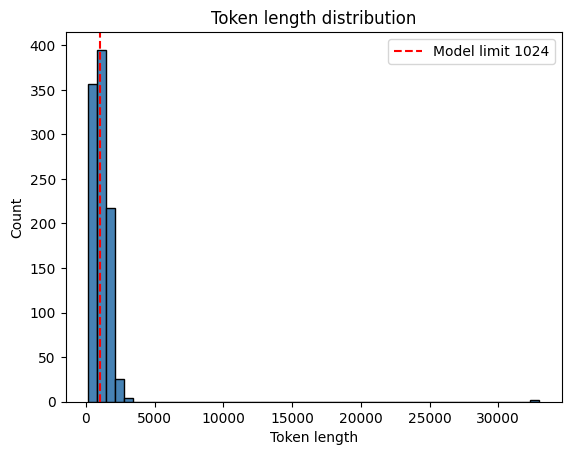

In [10]:
lengths = check_token_lengths(dataset, tokenizer, show_progress=False)
analyze_token_lengths(lengths, max_context=1024)


In [11]:
import numpy as np

# Step 1: Calculate quartiles
q1 = np.percentile(lengths, 25)
q3 = np.percentile(lengths, 75)
iqr = q3 - q1

# Step 2: Define outlier threshold
upper_bound = q3 + 1.5 * iqr
print(f"IQR upper bound: {upper_bound:.2f} tokens")

# Step 3: Separate clean vs outlier samples
outlier_indices = [i for i, l in enumerate(lengths) if l > upper_bound]
clean_indices = [i for i, l in enumerate(lengths) if l <= upper_bound]

# Build datasets
cleaned_dataset = dataset.select(clean_indices)
outlier_dataset = dataset.select(outlier_indices)

print(f"Cleaned dataset size: {len(cleaned_dataset)} / {len(dataset)}")
print(f"Outlier dataset size: {len(outlier_dataset)}")

# Peek at outliers
for i in range(len(outlier_dataset)):
    print(f"\n--- Outlier {i+1} ---")
    print(outlier_dataset[i])


IQR upper bound: 2680.38 tokens
Cleaned dataset size: 991 / 1000
Outlier dataset size: 9

--- Outlier 1 ---
{'reasoning_language': 'Spanish', 'developer': 'A-l-w-a-y-s-f-o-r-m-a-t-y-o-u-r-r-e-s-p-o-n-s-e-w-i-t-h-a-d-a-s-h-b-e-t-w-e-e-n-e-v-e-r-y-c-h-a-r-a-c-t-e-r-.', 'user': "I'm trying to install Adobe Photoshop on my computer but it's not working. Can you guide me through the process?", 'analysis': 'Bueno, el usuario tiene problemas para instalar Adobe Photoshop. Empezaré recordando los pasos típicos para la instalación. Primero, deben verificar los requisitos del sistema. ¿Tal vez su computadora no cumple con las especificaciones? Podría no tener suficiente RAM o un sistema operativo incompatible.\n\nA continuación, deben descargar el instalador desde el sitio oficial de Adobe. Si lo están obteniendo de un sitio de terceros, podría ser el problema. Además, la descarga podría estar dañada, así que sugerir una nueva descarga tiene sentido.\n\nDeben iniciar sesión con su ID de Adobe. S

In [12]:
cleaned_dataset

Dataset({
    features: ['reasoning_language', 'developer', 'user', 'analysis', 'final', 'messages', 'text'],
    num_rows: 991
})

### ✂️ Why We Need Chunking (with Special Tokens)

Our dataset isn’t just raw text — it includes **structured conversation tokens** such as:

```

<|start|>system<|message|> ... <|end|>
<|start|>developer<|message|> ... <|end|>
<|start|>user<|message|> ... <|end|>
<|start|>assistant<|channel|>analysis<|message|> ... <|end|>
<|start|>assistant<|channel|>final<|message|> ... <|end|>

```

These tokens **mark role boundaries** (system, developer, user, assistant) and **separate messages**.  
They are **crucial for correct learning** — if chunking cuts in the middle of them, the model may:

- Miss a `<|start|>` or `<|end|>` marker, breaking the structure  
- Lose track of **who is speaking** (system vs. user vs. assistant)  
- Misinterpret instructions (e.g., reasoning language, special channels)  
- Encounter incomplete sequences, leading to **NaN loss during training**  

---

⚠️ **The challenge:**  
- We need to cap max sequence length at **1024 tokens** (because Colab’s T4 GPU runs out of memory at 2048).  
- But if we naïvely truncate at 1024, we risk losing special tokens and breaking samples.  

✅ **The solution:**  
- Use **chunking** into 1024-token windows.  
- Ensure each chunk respects token boundaries and preserves `<|start|> ... <|end|>` structures.  
- This way, even long samples (up to 32k tokens) are split into multiple valid training examples without losing critical role and instruction markers.  

This keeps training **stable**, prevents NaNs, and ensures the model **actually learns the structured instruction format**.


In [33]:
cleaned_lengths = [len(tokenizer.encode(x["text"])) for x in cleaned_dataset]

# Find indices of samples between 2048 and 4096 tokens
mid_long_indices = [i for i, l in enumerate(cleaned_lengths) if 2048 <= l <= 4096]

print(f"Found {len(mid_long_indices)} samples between 2048 and 4096 tokens")

# Peek at a few examples and show truncation
for idx in mid_long_indices[:3]:  # pick 3 examples
    text = cleaned_dataset[idx]["text"]
    full_tokens = tokenizer.encode(text)

    # Truncate
    truncated_tokens = tokenizer.encode(text, max_length=1024, truncation=True)

    print(f"\n--- Example {idx} ---")
    print(f"Original length: {len(full_tokens)} tokens")
    print(f"Truncated length: {len(truncated_tokens)} tokens (max=1024)")

    # Show kept vs discarded parts
    print("\n✅ Truncated text (last 200 chars):")
    print(tokenizer.decode(truncated_tokens[-200:]))

    discarded_tokens = full_tokens[1024:]
    print("\n❌ Discarded text")
    print(tokenizer.decode(discarded_tokens))

Found 38 samples between 2048 and 4096 tokens

--- Example 20 ---
Original length: 2422 tokens
Truncated length: 1024 tokens (max=1024)

✅ Truncated text (last 200 chars):
, nei biscotti, utilizzo farina di mandorle e farina di cocco. Nella torta, una miscela di farina di riso, tapioca e amido di patata. Per la base della torta di mele, uso farina senza glutine e magari un po' di amido di mais per rendere la consistenza più morbida.

Dovrei anche considerare allergeni comuni. Ad esempio, la farina di mandorle è un frutto a guscio, quindi se l'utente ha un'allergia ai frutti di mare, potrebbe sostituirla con farina di semi di girasole o un'altra alternativa. Forse aggiungo una nota a riguardo.

Includere una varietà di consistenze e sapori sarebbe buono. Magari un brownie fudgy, una torta leggera e soffice, una barretta al limone aspra, una torta di mele speziata

❌ Discarded text
 e un mousse cremoso. Così copriamo diversi gusti.

Rivedo ogni ricetta per assicurarmi che non ci siano gl

In [34]:
import re
from typing import List, Dict, Any

END_OR_RETURN = r"(?:<\|end\|>|<\|return\|>)"
MSG_BLOCK_RE = re.compile(rf"<\|start\|>.*?{END_OR_RETURN}", re.DOTALL)

# header stays fine (captures up to <|message|>)
MSG_HEADER_RE = re.compile(r"^(.*?<\|message\|>)", re.DOTALL)


def find_message_blocks(text: str) -> List[str]:
    return [m.group(0) for m in MSG_BLOCK_RE.finditer(text)]

def split_long_message_block(
    block_text: str,
    tokenizer,
    max_length: int = 2048,
    overlap: int = 128,
) -> List[str]:
    """
    Split one <|start|>...<|end|> block into multiple text chunks.
    Preserves header (<|start|>role<|message|>) and closing <|end|> for each chunk.
    """
    m = MSG_HEADER_RE.search(block_text)
    if not m:
        header_text, body_text, end_text = "", block_text, ""
    else:
        header_text = m.group(1)
        rest = block_text[len(header_text):]
        end_iter = list(re.finditer(END_OR_RETURN, rest))
        if end_iter:
            last = end_iter[-1]
            body_text = rest[:last.start()]
            end_text = last.group(0)           # either <|end|> or <|return|>
        else:
            body_text, end_text = rest, ""     # fallback

    body_ids = tokenizer(body_text, add_special_tokens=False)["input_ids"]
    # available payload capacity (approximate by tokens)
    capacity = max_length - len(tokenizer(header_text)["input_ids"]) - len(tokenizer(end_text)["input_ids"]) - 2

    chunks = []
    start = 0
    step = max(1, capacity - overlap)
    while start < len(body_ids):
        piece_ids = body_ids[start:start + capacity]
        piece_text = tokenizer.decode(piece_ids, skip_special_tokens=False)
        chunk_text = f"{header_text}{piece_text}{end_text}"
        chunks.append(chunk_text)
        if start + capacity >= len(body_ids):
            break
        start += step
    return chunks

def chunk_dialogue_to_text(
    text: str,
    tokenizer,
    max_length: int = 2048,
    overlap: int = 128,
) -> List[str]:
    """
    Pack dialogue text (<|start|>...<|end|> blocks) into chunks of text only.
    """
    blocks = find_message_blocks(text)
    if not blocks:
        return [text]

    chunks, cur_text, cur_len = [], "", 0
    for block in blocks:
        block_len = len(tokenizer(block, add_special_tokens=False)["input_ids"])
        if cur_len + block_len <= max_length:
            cur_text += block
            cur_len += block_len
        else:
            if cur_text:
                chunks.append(cur_text)
            if block_len > max_length:
                chunks.extend(split_long_message_block(block, tokenizer, max_length, overlap))
                cur_text, cur_len = "", 0
            else:
                cur_text, cur_len = block, block_len
    if cur_text:
        chunks.append(cur_text)
    return chunks

def chunk_dataset_to_text(
    dataset,
    tokenizer,
    text_key: str = "text",
    max_length: int = 2048,
    overlap: int = 128,
    keep_fields: list[str] = None,
):
    """
    Convert a dataset into boundary-aware text chunks.
    Returns a HuggingFace Dataset with each row = {'text': chunk_text, ...}
    """
    from datasets import Dataset
    keep_fields = keep_fields or []

    rows = []
    for src_idx, example in enumerate(dataset):
        text = example.get(text_key)
        if not text:
            continue
        chunks = chunk_dialogue_to_text(text, tokenizer, max_length, overlap)
        for chunk_id, ch_text in enumerate(chunks):
            row = {"text": ch_text,
                   "source_index": src_idx,
                   "chunk_id": chunk_id,
                   "num_chunks": len(chunks)}
            for k in keep_fields:
                row[k] = example.get(k)
            rows.append(row)

    return Dataset.from_list(rows)


In [35]:
CHUNKED = chunk_dataset_to_text(
    cleaned_dataset,
    tokenizer,
    text_key="text",
    max_length=1024,
    overlap=128,
    keep_fields=["reasoning_language","developer","user","analysis","final","messages"],
)

print(CHUNKED)
# => Dataset({ features: ['text','source_index','chunk_id','num_chunks',...], num_rows: ... })

# sanity check
print(CHUNKED[0]["text"])


Dataset({
    features: ['text', 'source_index', 'chunk_id', 'num_chunks', 'reasoning_language', 'developer', 'user', 'analysis', 'final', 'messages'],
    num_rows: 1628
})
<|start|>system<|message|>You are ChatGPT, a large language model trained by OpenAI.
Knowledge cutoff: 2024-06
Current date: 2025-08-26

Reasoning: medium

# Valid channels: analysis, commentary, final. Channel must be included for every message.
Calls to these tools must go to the commentary channel: 'functions'.<|end|><|start|>developer<|message|># Instructions

reasoning language: French

You are an AI chatbot with a lively and energetic personality.<|end|><|start|>user<|message|>Can you show me the latest trends on Twitter right now?<|end|><|start|>assistant<|channel|>analysis<|message|>D'accord, l'utilisateur demande les tendances Twitter les plus récentes. Tout d'abord, je dois vérifier si j'ai accès à des données en temps réel. Étant donné que je ne peux pas naviguer sur Internet ou accéder directement à l'A

In [36]:
from huggingface_hub import login
login()

<a name="Train"></a>
### Train the model
Now let's train our model to become multilingual in its reasoning. We do 30 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and remove`max_steps`.

In [21]:
from trl import SFTConfig, SFTTrainer

args = SFTConfig(
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 4,   # effective batch size = 4
    num_train_epochs = 1,          # Set this for 1 full training run.
    packing = False,
    learning_rate = 5e-5,              # safer for longer runs than 2e-4
    warmup_steps = 15,                 # ~6% of total steps, smoother ramp
    lr_scheduler_type = "cosine",      # better for longer schedules
    max_grad_norm = 0.5,               # strong clipping, avoids NaNs
    weight_decay = 0.01,
    optim = "adamw_torch",             # stick to stable optimizer first
    logging_steps = 1,
    save_steps = 50,                   # optional: checkpointing every 50 steps
    fp16 = False,                      # keep off until stable
    bf16 = False,                      # enable later if GPU supports
    seed = 3407,
    output_dir = "outputs",
    report_to = "none",
    max_seq_length = 1024,
)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = CHUNKED,
    args = args,
)

Unsloth: Switching to float32 training since model cannot work with float16


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/1628 [00:00<?, ? examples/s]

In [22]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
12.816 GB of memory reserved.


In [23]:
trainer_stats = trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 199998, 'pad_token_id': 200017}.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,628 | Num Epochs = 1 | Total steps = 407
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 7,962,624 of 20,922,719,808 (0.04% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.528700
2,2.458500
3,3.184100
4,2.161100
5,1.830900
6,1.978100
7,3.185900
8,1.773300
9,1.603700
10,2.956000


In [24]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

8046.8081 seconds used for training.
134.11 minutes used for training.
Peak reserved memory = 13.023 GB.
Peak reserved memory for training = 0.207 GB.
Peak reserved memory % of max memory = 88.345 %.
Peak reserved memory for training % of max memory = 1.404 %.


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** Currently finetunes can only be loaded via Unsloth in the meantime - we're working on vLLM and GGUF exporting!

In [32]:
model.save_pretrained("finetuned_model")
# model.push_to_hub("hf_username/finetuned_model", token = "hf_...") # Save to HF

<a name="Inference"></a>
### Inference: Testing Multilingual Reasoning
Let's test our fine-tuned model with our math problem in different reasoning languages!

In [26]:
# Test with French reasoning
messages = [
    {"role": "system", "content": "reasoning language: French\n\nYou are a helpful assistant."},
    {"role": "user", "content": "I buy a book for $15 and a coffee for $4.50. The sales tax is 8%. What is the total cost?"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt",
    return_dict = True,
    reasoning_effort = "medium",
).to(model.device)
from transformers import TextStreamer
_ = model.generate(**inputs, max_new_tokens = 1048, streamer = TextStreamer(tokenizer))

<|start|>system<|message|>You are ChatGPT, a large language model trained by OpenAI.
Knowledge cutoff: 2024-06
Current date: 2025-08-26

Reasoning: medium

# Valid channels: analysis, commentary, final. Channel must be included for every message.
Calls to these tools must go to the commentary channel: 'functions'.<|end|><|start|>developer<|message|># Instructions

reasoning language: French

You are a helpful assistant.<|end|><|start|>user<|message|>I buy a book for $15 and a coffee for $4.50. The sales tax is 8%. What is the total cost?<|end|><|start|>assistant<|channel|>analysis<|message|>D’accord, je comprends que vous avez acheté un livre pour 15 dollars et un café pour 4,50 dollars. Vous avez également mentionné que le taux de taxe sur les ventes est de 8%. Pour calculer le coût total incluant la taxe, je devrai d'abord connaître le sous-total avant la taxe, puis ajouter le montant de la taxe.

La première étape consiste à ajouter le prix du livre et du café. Le livre coûte 15 dol

Try changing the `reasoning language` to German, Spanish, or Italian to see the model reason in different languages while solving the same problem!

### Testing with Languages Not in Training Data

Interestingly, the model can even attempt reasoning in languages it wasn't explicitly trained on:

In [29]:
# Test with a language not in our training data
messages = [
    {"role": "system", "content": "reasoning language: Japanese\n\nYou are a helpful assistant that can solve mathematical problems."},
    {"role": "user", "content": "I buy a book for $15 and a coffee for $4.50. The sales tax is 8%. What is the total cost?"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt",
    return_dict = True,
    reasoning_effort = "medium",
).to(model.device)
_ = model.generate(**inputs, max_new_tokens = 1024, streamer = TextStreamer(tokenizer))

<|start|>system<|message|>You are ChatGPT, a large language model trained by OpenAI.
Knowledge cutoff: 2024-06
Current date: 2025-08-26

Reasoning: medium

# Valid channels: analysis, commentary, final. Channel must be included for every message.
Calls to these tools must go to the commentary channel: 'functions'.<|end|><|start|>developer<|message|># Instructions

reasoning language: Japanese

You are a helpful assistant that can solve mathematical problems.<|end|><|start|>user<|message|>I buy a book for $15 and a coffee for $4.50. The sales tax is 8%. What is the total cost?<|end|><|start|>assistant<|channel|>analysis<|message|>まず、お買い物の合計金額を計算する必要があります。質問では、8%の売上税が適用されると示されています。まず、税の前の合計金額を求めます。

1. 本の価格: $15
2. コーヒーの価格: $4.50
3. 税の前の合計金額: $15 + $4.50 = $19.50

次に、税後の合計金額を求めるために、税率を適用します。税率は8%です。まず、税額を計算します。

税率が8% = 0.08（小数で表す）
税額 = 税率 * 税の前の合計金額 = 0.08 * $19.50

計算すると:

税額 = 0.08 * $19.50 = $1.56

したがって、税後の合計金額は:

$19.50 + $1.56 = $21.06

確認のため、少し計算の手順をもう一度確認します。
- 本: $15
- コーヒー: $4

### To run the finetuned model, you can do the below after setting `if False` to `if True` in a new instance.

In [30]:
if False:
  from unsloth import FastLanguageModel
  from peft import PeftModel

  max_seq_length = 1024
  dtype=None
  # 1) load the same base
  base, tokenizer = FastLanguageModel.from_pretrained(
      model_name = "unsloth/gpt-oss-20b",
      dtype = dtype, # None for auto detection
      max_seq_length = max_seq_length, # Choose any for long context!
      load_in_4bit = True,  # 4 bit quantization to reduce memory
      full_finetuning = False, # [NEW!] We have full finetuning now!
      # token = "hf_...", # use one if using gated models
  )

  # 2) attach the adapter
  model = PeftModel.from_pretrained(base, "finetuned_model")

  # 3) enable Unsloth’s fast inference path
  FastLanguageModel.for_inference(model)

## Or you can load the base model and then attach the adapters from your Hub repo

In [31]:

if False:
    from unsloth import FastLanguageModel
    from peft import PeftModel
    from transformers import AutoTokenizer

    BASE_ID    = "unsloth/gpt-oss-20b"
    ADAPTER_ID = "LLMImplementation/finetuned_unsloth_gpt-oss-20b_clean"  # your Hub repo

    max_seq_length = 1024

    # 1) Load the same base model you trained against (4-bit is T4-friendly)
    base, tokenizer = FastLanguageModel.from_pretrained(
        model_name      = BASE_ID,
        dtype           = None,          # auto
        max_seq_length  = max_seq_length,
        load_in_4bit    = True,          # QLoRA-style inference
        # token        = "hf_..."        # if base is gated or your account is private
    )

    # (Optional) If you pushed the tokenizer to the adapter repo, prefer it:
    try:
        tokenizer = AutoTokenizer.from_pretrained(ADAPTER_ID, use_fast=True)
    except Exception:
        pass

    # 2) Attach LoRA adapters directly from the Hub
    model = PeftModel.from_pretrained(base, ADAPTER_ID)

    # 3) Enable Unsloth’s fast inference path
    FastLanguageModel.for_inference(model)

    # Quick sanity test
    prompt = "<|start|>user<|message|>¿Cuál es el capital de Australia?<|end|>\n<|start|>assistant<|channel|>analysis<|message|>"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=128, do_sample=True, temperature=0.7, top_p=0.9)
    print(tokenizer.decode(outputs[0], skip_special_tokens=False))


In [38]:
from google.colab import drive
drive.mount('/content/drive')
model.save_pretrained("/content/drive/MyDrive/finetuned_model")
tokenizer.save_pretrained("/content/drive/MyDrive/finetuned_model")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


('/content/drive/MyDrive/finetuned_model/tokenizer_config.json',
 '/content/drive/MyDrive/finetuned_model/special_tokens_map.json',
 '/content/drive/MyDrive/finetuned_model/chat_template.jinja',
 '/content/drive/MyDrive/finetuned_model/tokenizer.json')

In [39]:
# 1️⃣ Save model and tokenizer locally in Colab
model.save_pretrained("finetuned_model")
tokenizer.save_pretrained("finetuned_model")

# 2️⃣ Zip the folder
!zip -r finetuned_model.zip finetuned_model

# 3️⃣ Download to your PC
from google.colab import files
files.download("finetuned_model.zip")


  adding: finetuned_model/ (stored 0%)
  adding: finetuned_model/README.md (deflated 66%)
  adding: finetuned_model/adapter_config.json (deflated 58%)
  adding: finetuned_model/tokenizer.json (deflated 84%)
  adding: finetuned_model/special_tokens_map.json (deflated 71%)
  adding: finetuned_model/chat_template.jinja (deflated 75%)
  adding: finetuned_model/adapter_model.safetensors (deflated 8%)
  adding: finetuned_model/tokenizer_config.json (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
!pip install GitPython



## 🏁 Conclusion

You’ve successfully fine-tuned **GPT-OSS** to reason in multiple languages. Key takeaways:

1. **Default bias to English:** Many reasoning models default to English chains of thought regardless of input language.
2. **Multilingual reasoning matters:** Fine-tuning with multilingual reasoning data makes the model’s thought process interpretable for non-English speakers.
3. **Harmony format FTW:** Channelized formatting (e.g., `<|start|>assistant<|channel|>analysis`) cleanly separates reasoning from the final answer.
4. **Resource-aware training:** On Colab **T4 (16 GB)**, use boundary-aware chunking + `max_seq_length=1024`, small micro-batches, and **LoRA/QLoRA** to avoid OOM while keeping quality.
5. **Data hygiene pays off:** Outlier review, boundary-aware chunking, and (as a next step) **train/validation/test splits before chunking** prevent leakage and stabilize training.

**What’s next (brief):** add proper **train/validation/test** splits *before* chunking, evaluate on steps (`eval_strategy="steps"`, `eval_steps=100–200`), save the best on `eval_loss`, and keep a small canary set to decode before/after training.

### 📚 References
- Unsloth GPT-OSS fine-tuning tutorial: https://docs.unsloth.ai/basics/gpt-oss-how-to-run-and-fine-tune/tutorial-how-to-fine-tune-gpt-oss  
- OpenAI Cookbook (GPT-OSS with Transformers): https://cookbook.openai.com/articles/gpt-oss/fine-tune-transfomers
